## 初始化

引入Oneke相关的的库

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, SegResNet, VNet, UNETR
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import sys

### 数据集划分

默认进行随机划分，使用最后的8个作为测试集合。

`seg_idx = 1`可以通过修改seg_idx的值选择训练那个模型

  1. `1`代表训练T1
  2. `2`代表训练T2

In [2]:
import random
import os
import nibabel as nib
import numpy as np
import json
import pandas as pd
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.Radiology import diagnose_3d_image_mask_settings

root_dir = r'D:\20240420-LiXiaoFeng'
data_dir= os.path.join(root_dir, 'data')
val_data_dir= os.path.join(root_dir, 'test')
inference_dir= os.path.join(root_dir, 'test_results')
model_root = os.path.join(root_dir, 'models')
os.makedirs(model_root, exist_ok=True)
# os.makedirs(inference_dir, exist_ok=True)
roi_size = (96, 96, 96)

# 这里选择任务类型
sel_modal = 'CLS2'
train_files = []
data = pd.read_csv('data/group.csv')
data['ID'] = data['ID'].map(lambda x: x.replace('.png', '.gz'))
for i in data['ID']:
# for i in data[data['group'] == 'train']['ID']:
    if os.path.exists(os.path.join(root_dir, 'vnet_crop', i.replace('.gz', '.png'))):
        train_files.append({'image': os.path.join(root_dir, 'images_re', i), 'label': os.path.join(root_dir, 'masks_re', i)})
train_files

[{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\CAO_BAO_HUA_P00190203.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\CAO_BAO_HUA_P00190203.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LIU_JIN_YING_P00304462.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\LIU_JIN_YING_P00304462.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LI JIU KUIP00335627.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\LI JIU KUIP00335627.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\zhou long ying.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\zhou long ying.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\Sun_Xiulan_P00468911.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\Sun_Xiulan_P00468911.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\Gao_Youying_P00189310.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\Gao_Youying_P00189310.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\WANG SI CHEN_P00343567

In [3]:
val_files = []
for i in data[data['group'] == 'val']['ID']:
    if os.path.exists(os.path.join(root_dir, 'vnet_infer', i)):
        val_files.append({'image': os.path.join(root_dir, 'images_re', i), 'label': os.path.join(root_dir, 'masks_re', i)})
val_files = val_files#[:20]
val_files

[{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\FENG_JUN_PING_P00301751.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\FENG_JUN_PING_P00301751.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\DONG_YU_MEI_P00175700.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\DONG_YU_MEI_P00175700.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\CHEN AI QIU_P00162124.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\CHEN AI QIU_P00162124.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LIU_XIU_YUN_P00194230.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\LIU_XIU_YUN_P00194230.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\ZHU_SHI_HUAN_P00291363.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\ZHU_SHI_HUAN_P00291363.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LIU SHIP00368368.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\LIU SHIP00368368.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\XU_QIANG

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [4]:
set_determinism(seed=0)
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=150,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=roi_size,
            pos=1,
            neg=2,
            num_samples=2,
#             image_key="image",
#             image_threshold=0,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=150,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

### Dataloader

检查Transform以及相应的Dataloader。

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  And set `num_workers` to enable multi-threads during caching.  If want to to try the regular Dataset, just change to use the commented code below.

In [5]:
# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1, num_workers=6)
train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=6)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.2, num_workers=6)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=12)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


#### 数据可视化

D:\20240420-LiXiaoFeng\images_re\WEI_ZHONG_YING_P00299720.nii.gz
image shape: (427, 427, 344)


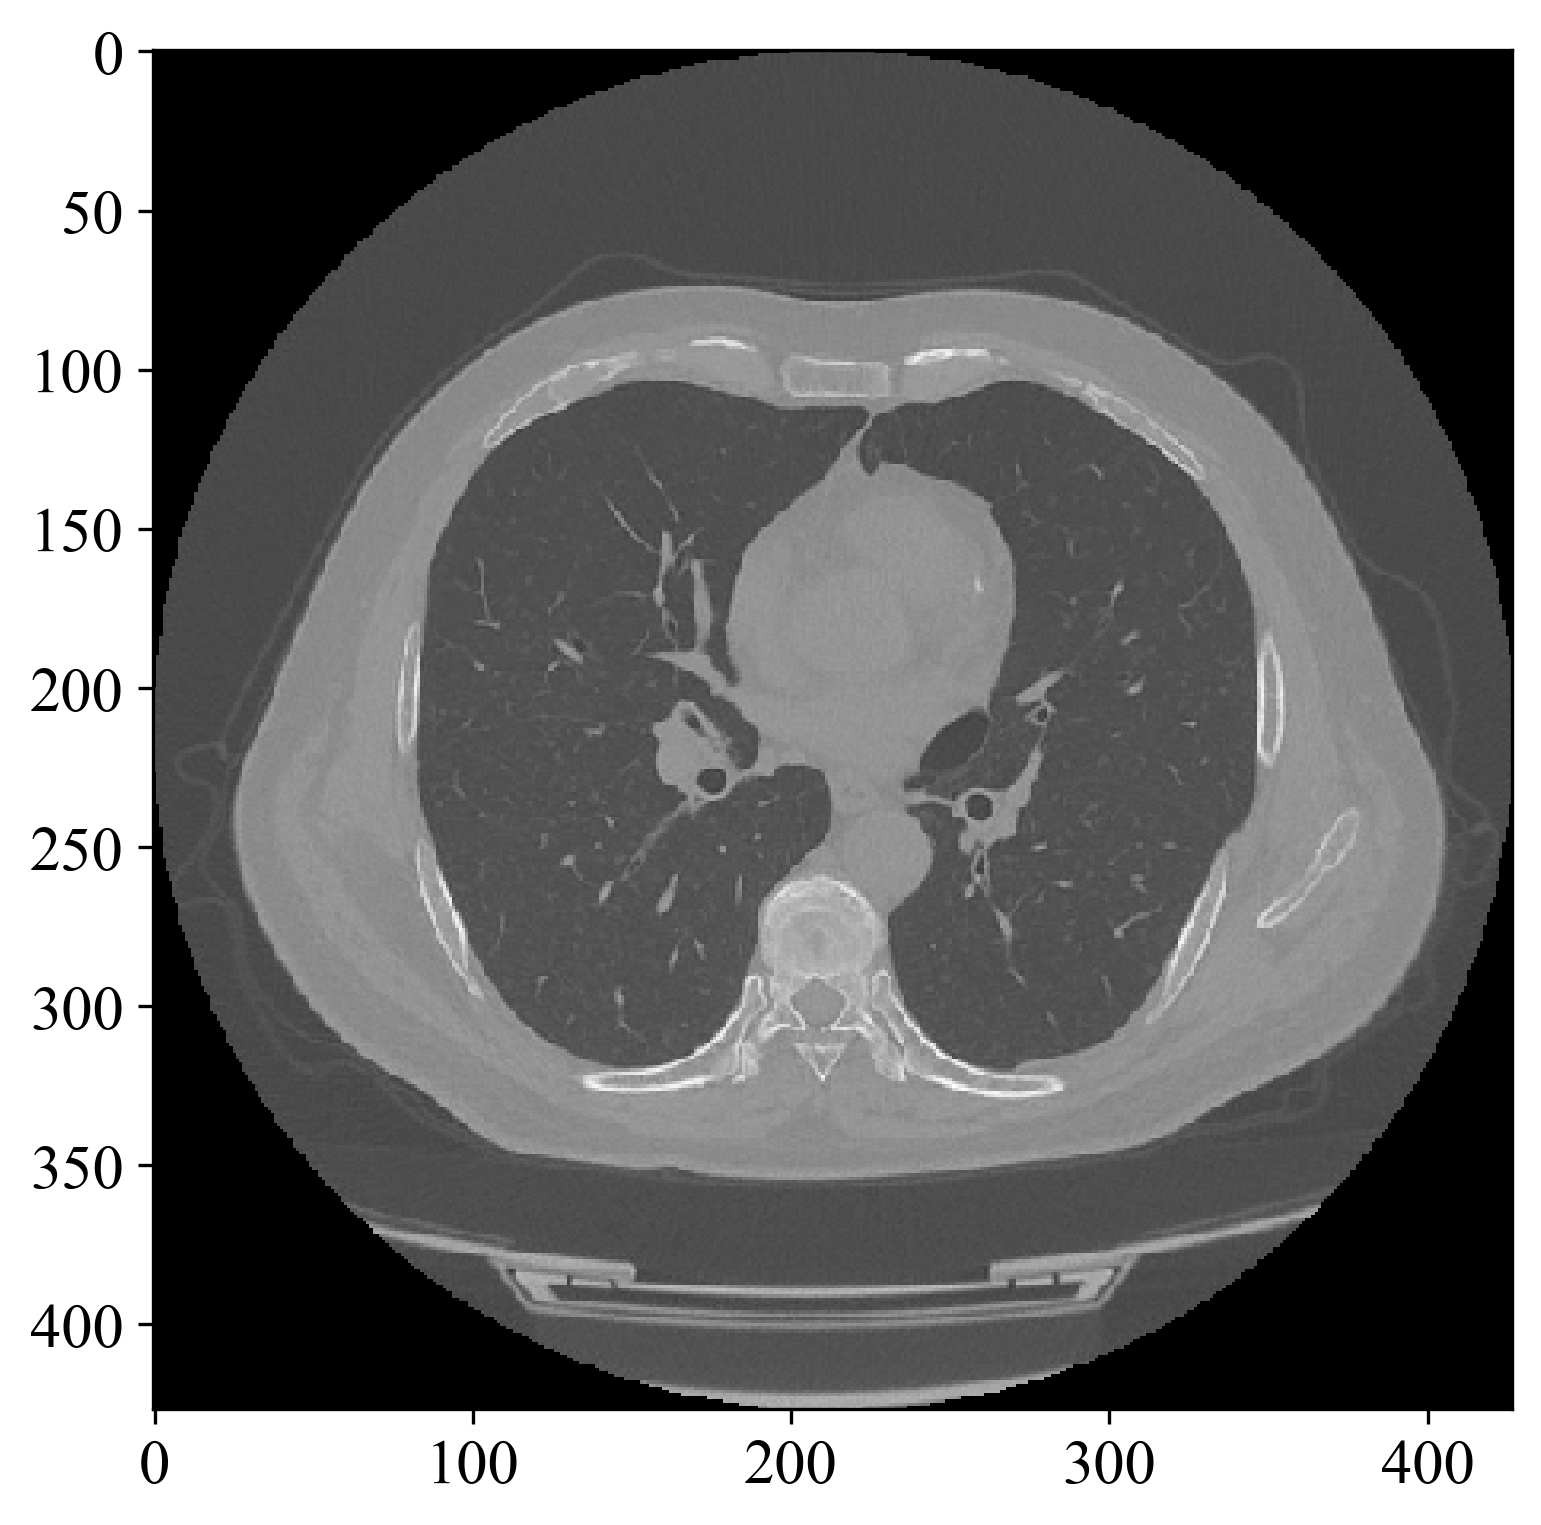

image shape: (427, 427, 344)


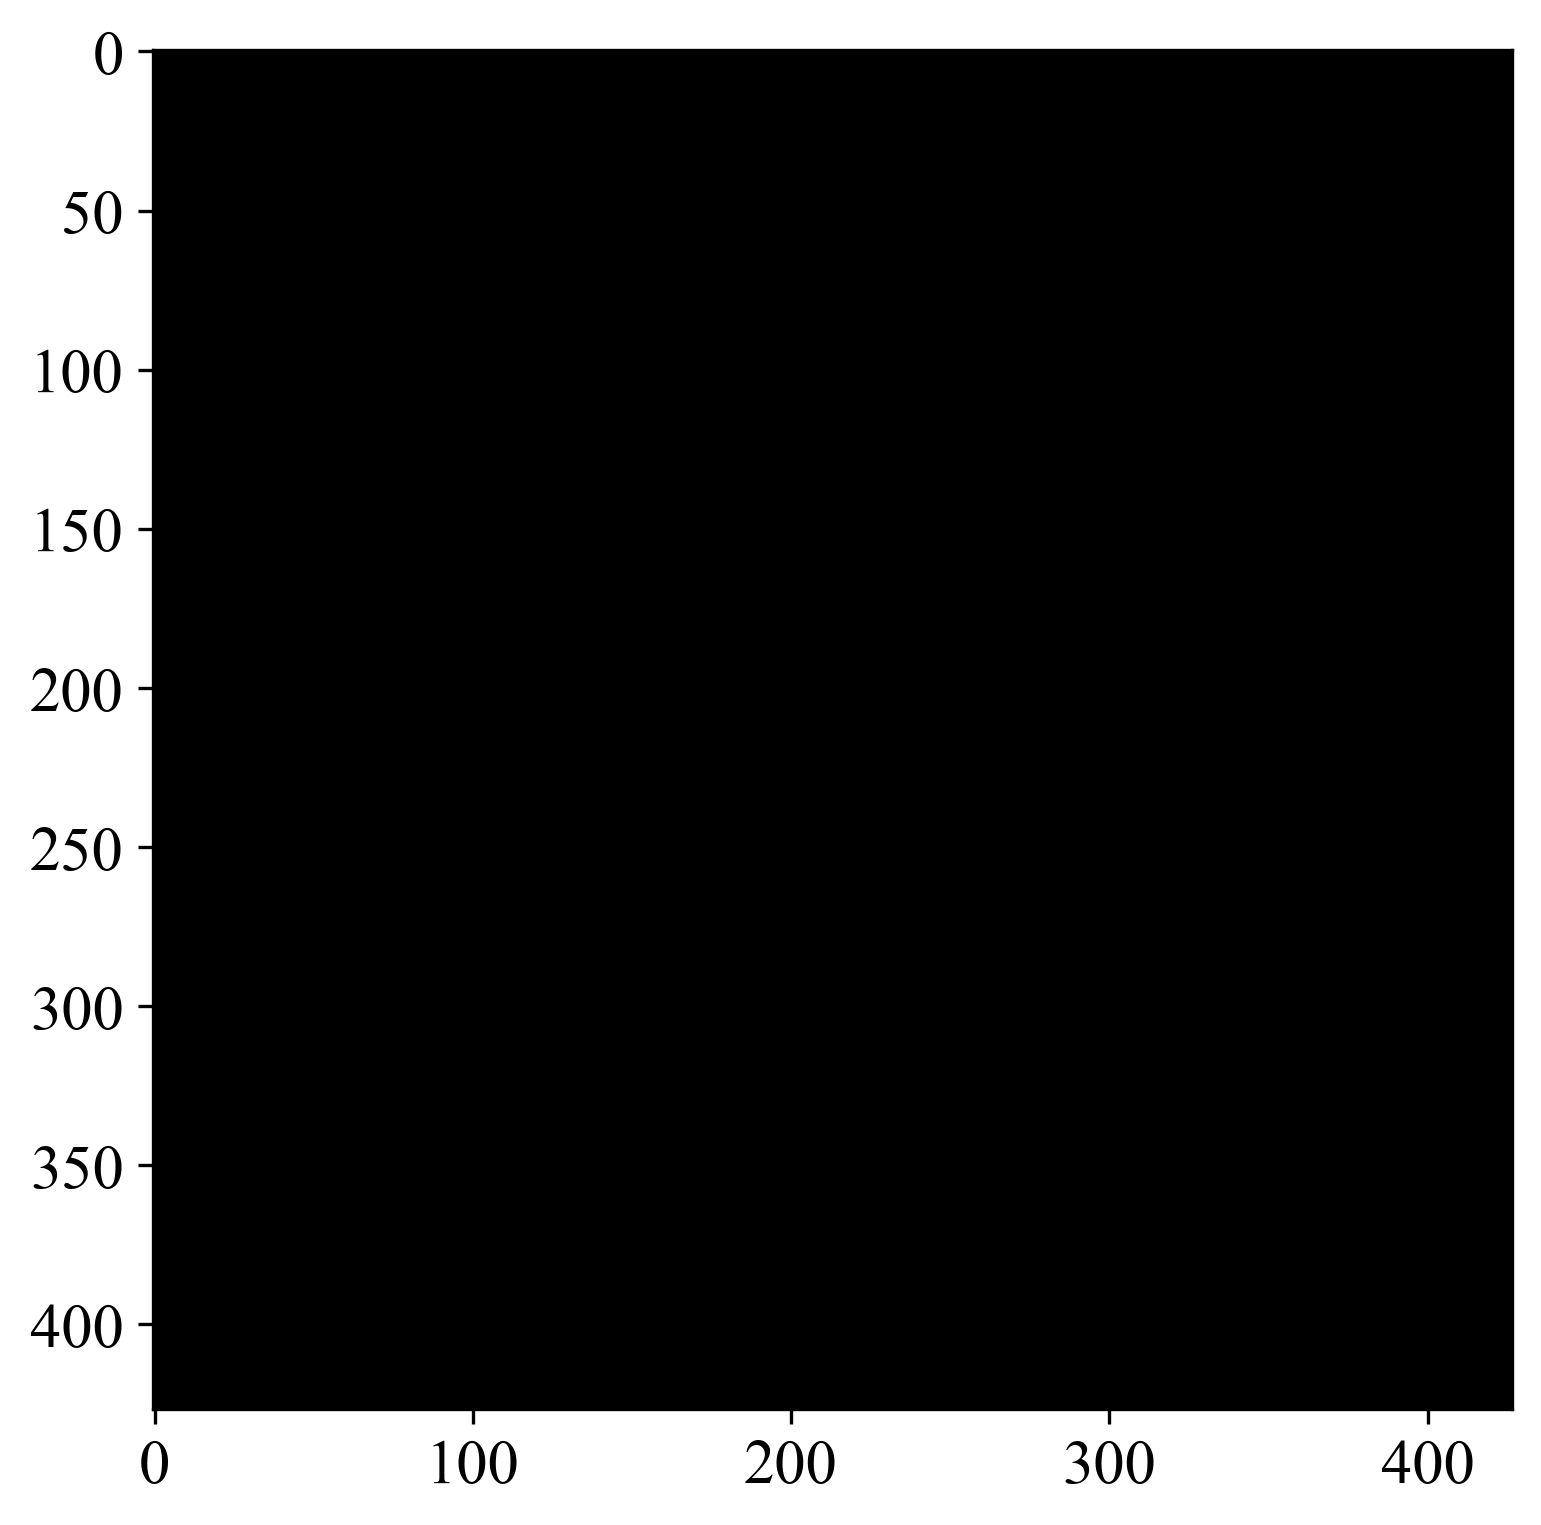

image shape: torch.Size([1, 427, 427, 344])


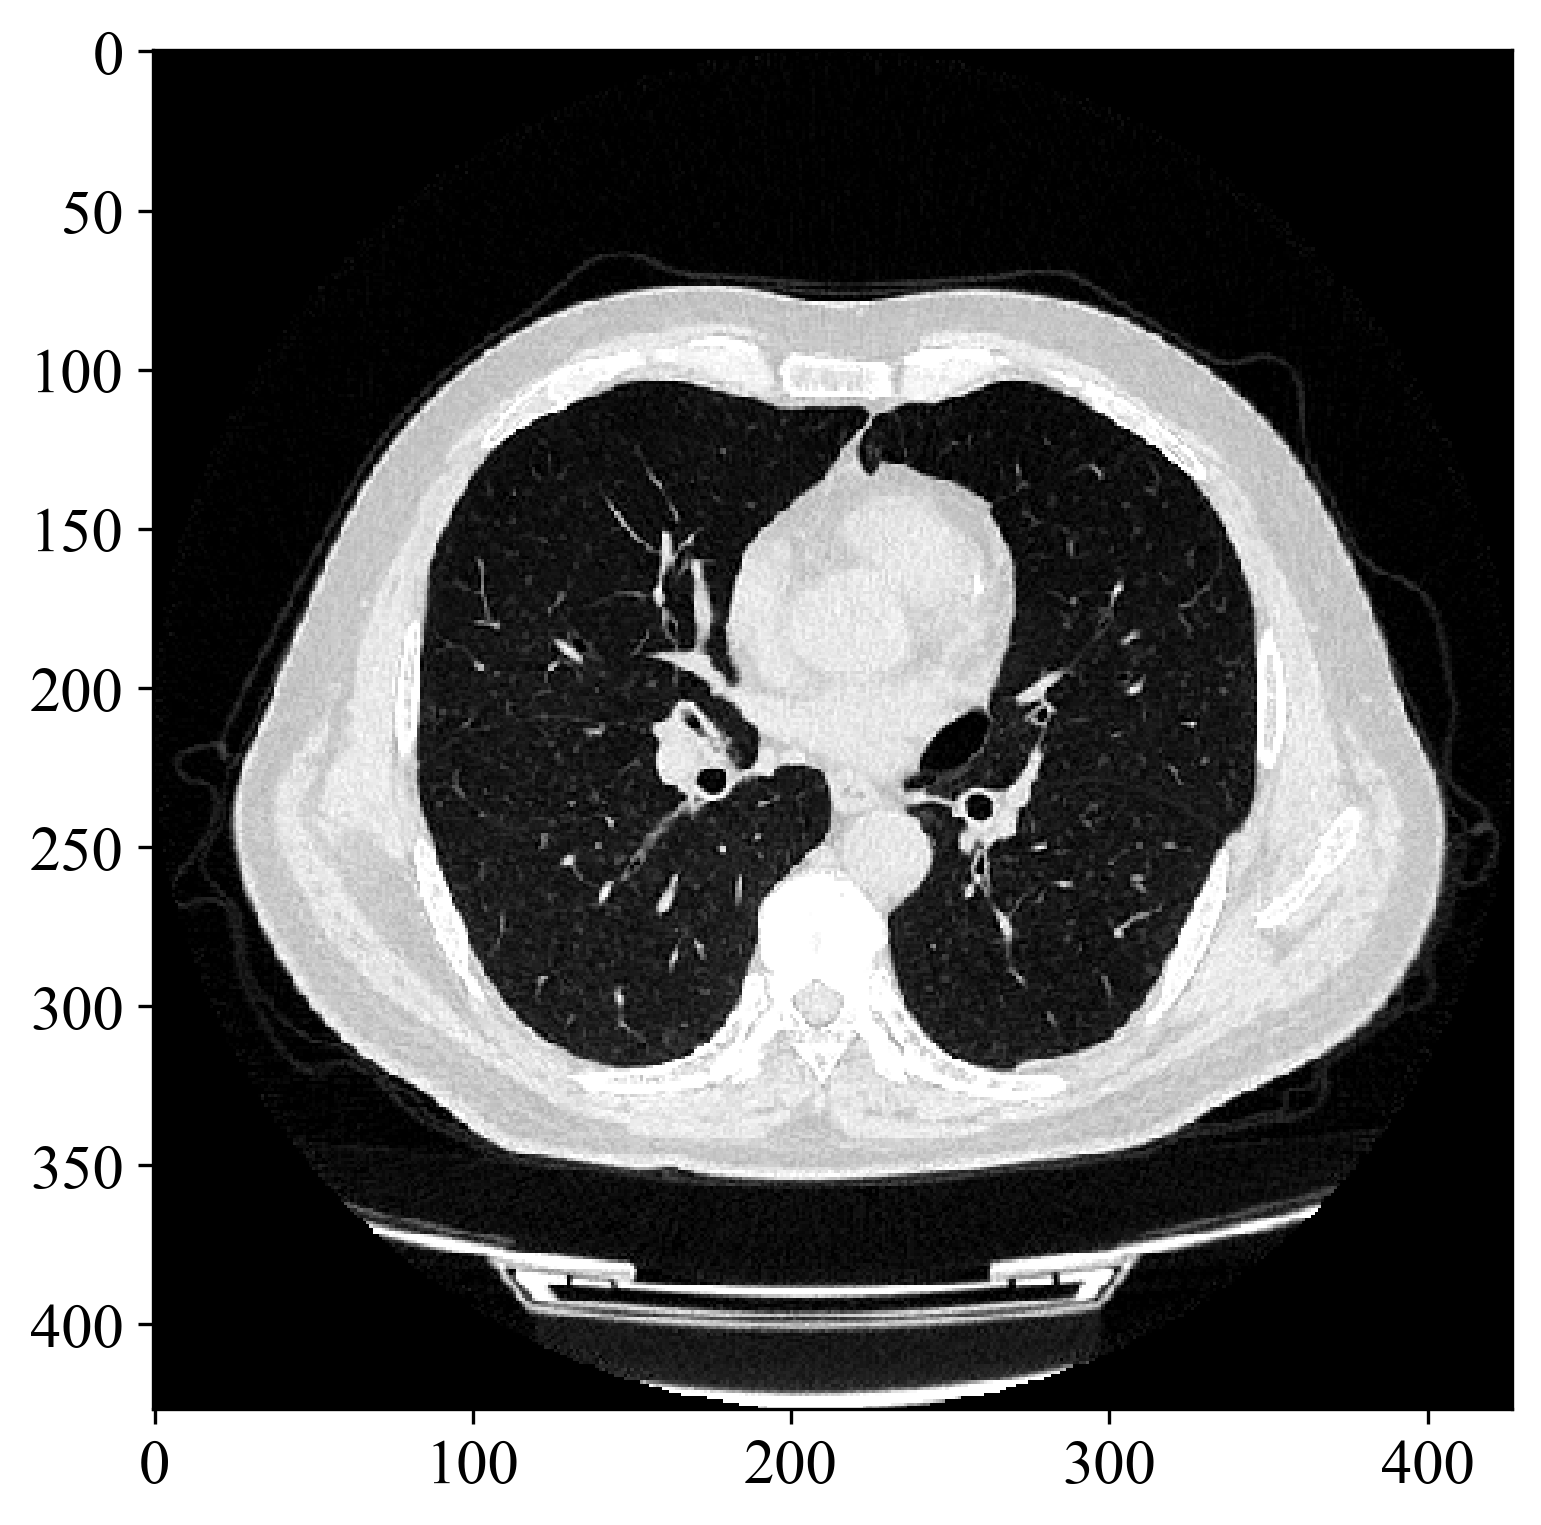

label shape: torch.Size([1, 427, 427, 344])


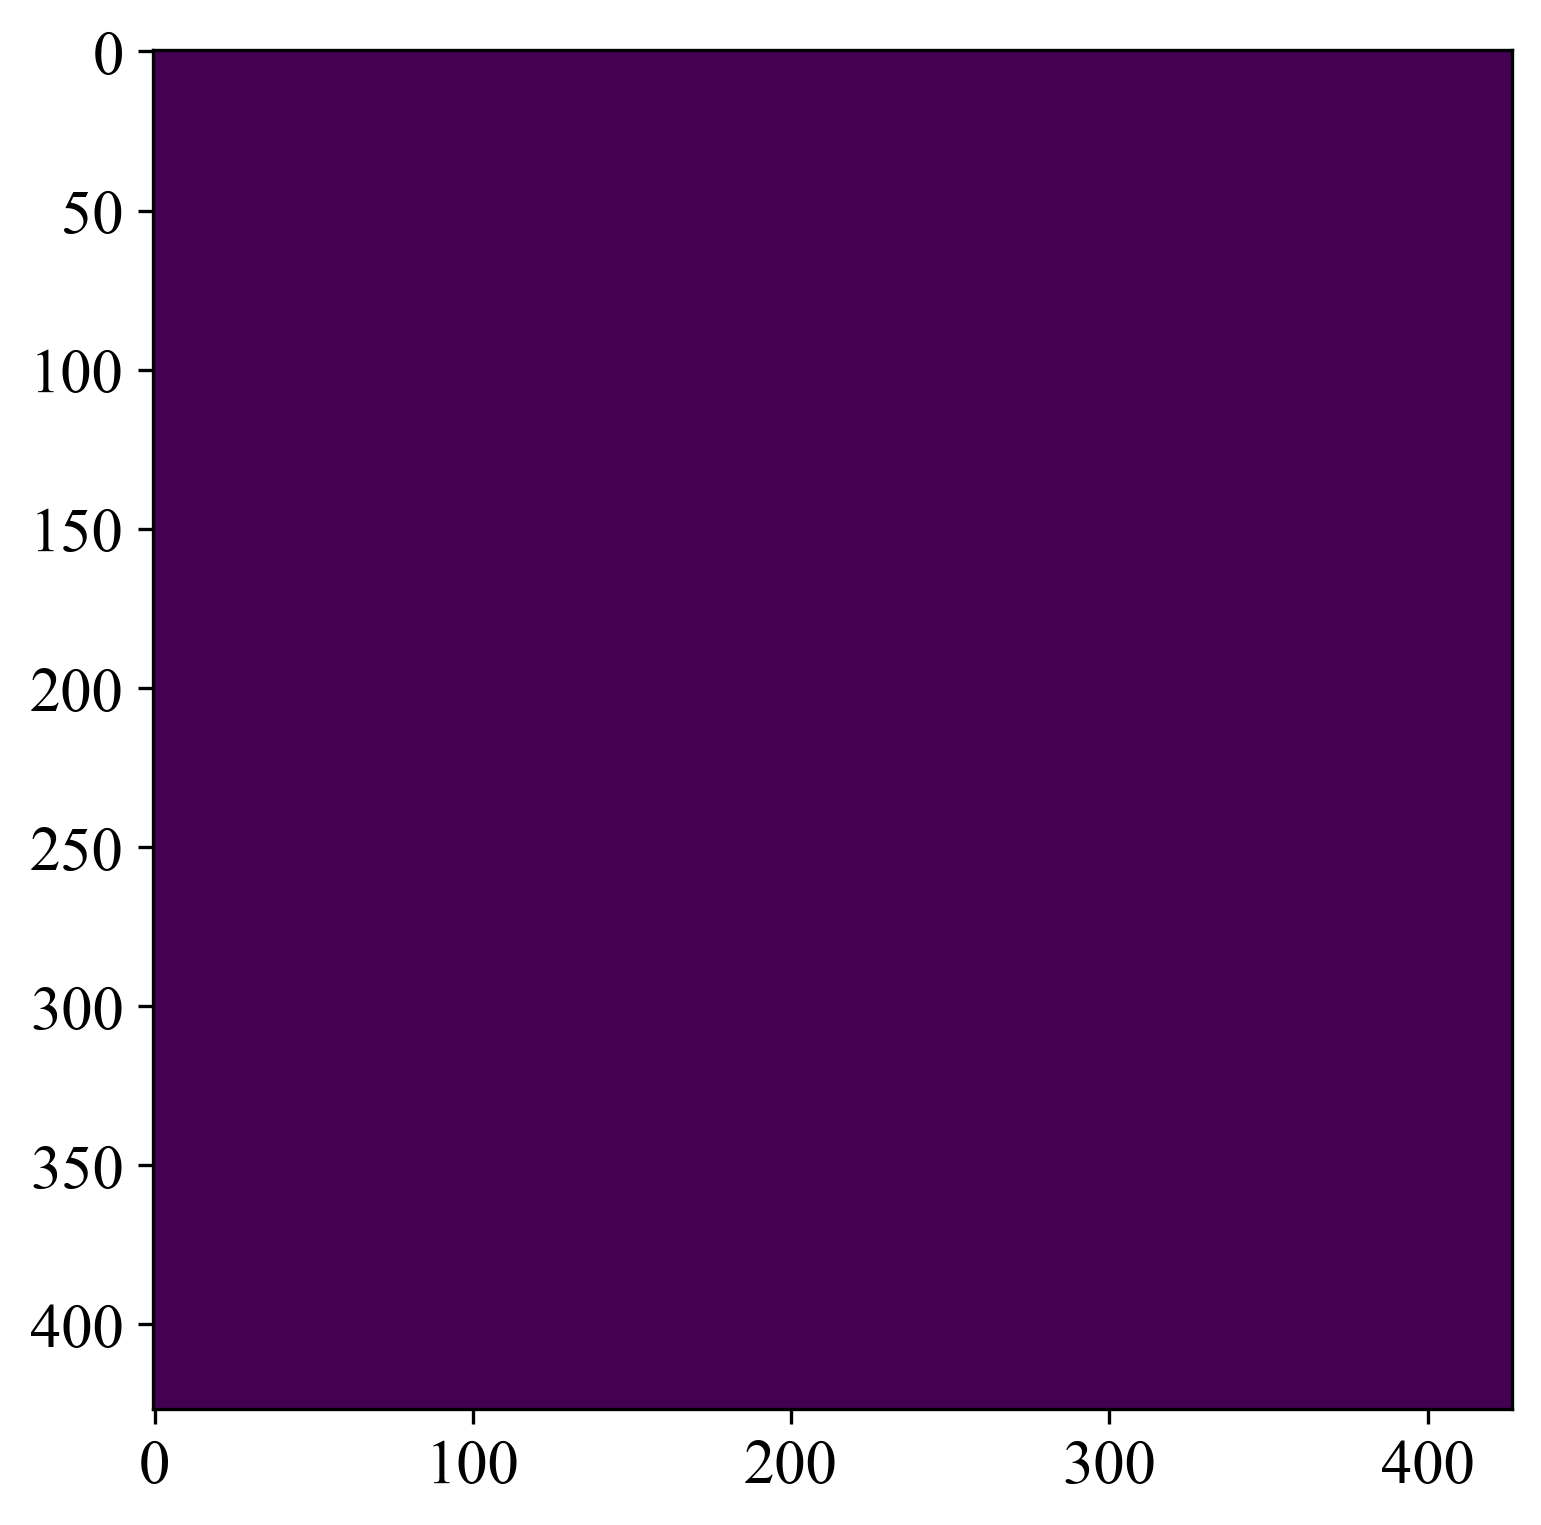

In [6]:
import nibabel as nib
import numpy as np
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(val_files[2]['image'])
val_data_example = np.array(nib.load(val_files[2]['image']).dataobj)
print(f"image shape: {val_data_example.shape}")
plt.figure("image", (24, 6))
plt.imshow(val_data_example[:, :, 183].T, cmap="gray")
plt.show()

val_data_example = np.array(nib.load(val_files[2]['label']).dataobj)
print(f"image shape: {val_data_example.shape}")
plt.figure("image", (24, 6))
plt.imshow(val_data_example[:, :, 183].T, cmap="gray")
plt.show()


val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
plt.imshow(val_data_example["image"][0, :, :, 183].T.detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (24, 6))
plt.imshow(val_data_example["label"][0, :, :, 183].T.detach().cpu())
plt.show()

In [7]:
np.unique(val_data_example['label'])

array([0., 1.], dtype=float32)

## 生成 Model, Loss, Optimizer

In [8]:
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceFocalLoss, DiceCELoss

device = torch.device(f"cuda:0")
mtype = 'vnet'
num_classes = 2
if mtype.lower() == 'unet':
    #Unet
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=num_classes,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
elif mtype.lower() == 'segresnet':
    #SegResNet
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=1,
        out_channels=num_classes,
        dropout_prob=0.2,
    ).to(device)
elif mtype.lower() == 'unetr':
    # UNETR
    model = UNETR(
        in_channels=1,
        out_channels=num_classes,
        img_size=(96, 96, 96),
        feature_size=16,
        hidden_size=768,
        mlp_dim=3072,
        num_heads=12,
        pos_embed="perceptron",
        norm_name="instance",
        res_block=True,
        dropout_rate=0.0,
    ).to(device)
elif mtype.lower() == 'vnet':
    model = VNet(spatial_dims=3, 
                 in_channels=1, 
                 out_channels=num_classes,
                 dropout_prob=0.2, 
                 dropout_dim=3, 
                 bias=False).to(device)
else:
    raise ValueError(f'{mtype} not found!')

print(f"使用{mtype.upper()}进行训练！")
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")
if os.path.exists(os.path.join(model_root, f"{mtype}_{sel_modal}.pth")):
    print('加载预训练模型...')
    model.load_state_dict(torch.load(os.path.join(model_root, f"{mtype}_{sel_modal}.pth"), map_location=device))

使用VNET进行训练！
加载预训练模型...


### 模型训练

`max_epochs`最大迭代次数，int类型，默认： 600

`val_interval` 多少次训练进行一次validation，默认： 2

In [14]:
max_epochs = 300
val_interval = 20
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=num_classes)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=num_classes)])
early_stopping_epoch = 1280
for epoch in range(200, max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
#         print(inputs.size())
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 2 == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % (val_interval if epoch < 200 else 2) == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            torch.save(model.state_dict(), os.path.join(model_root, f"{mtype}_{sel_modal}-Epoch{epoch+1}.pth"))
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 
                           os.path.join(model_root, f"{mtype}_{sel_modal}.pth"))
                print("saved new best metric model")
            if epoch - best_metric_epoch > early_stopping_epoch:
                print(f'Early Stop @{epoch+1}')
                break
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 201/300
2/72, train_loss: 0.0162
4/72, train_loss: 0.0488
6/72, train_loss: 0.0152
8/72, train_loss: 0.0331
10/72, train_loss: 0.0250
12/72, train_loss: 0.0324
14/72, train_loss: 0.0172
16/72, train_loss: 0.0180
18/72, train_loss: 0.0081
20/72, train_loss: 0.0128
22/72, train_loss: 0.0132
24/72, train_loss: 0.0736
26/72, train_loss: 0.0246
28/72, train_loss: 0.0178
30/72, train_loss: 0.0319
32/72, train_loss: 0.0139
34/72, train_loss: 0.0333
36/72, train_loss: 0.0931
38/72, train_loss: 0.0513
40/72, train_loss: 0.0201
42/72, train_loss: 0.0458
44/72, train_loss: 0.0269
46/72, train_loss: 0.0211
48/72, train_loss: 0.0385
50/72, train_loss: 0.0275
52/72, train_loss: 0.0085
54/72, train_loss: 0.0149
56/72, train_loss: 0.0182
58/72, train_loss: 0.0002
60/72, train_loss: 0.0156
62/72, train_loss: 0.0413
64/72, train_loss: 0.0130
66/72, train_loss: 0.0383
68/72, train_loss: 0.0270
70/72, train_loss: 0.0309
72/72, train_loss: 0.0099
epoch 201 average loss: 0.0328
----------
e

KeyboardInterrupt: 

### 打印训练过程

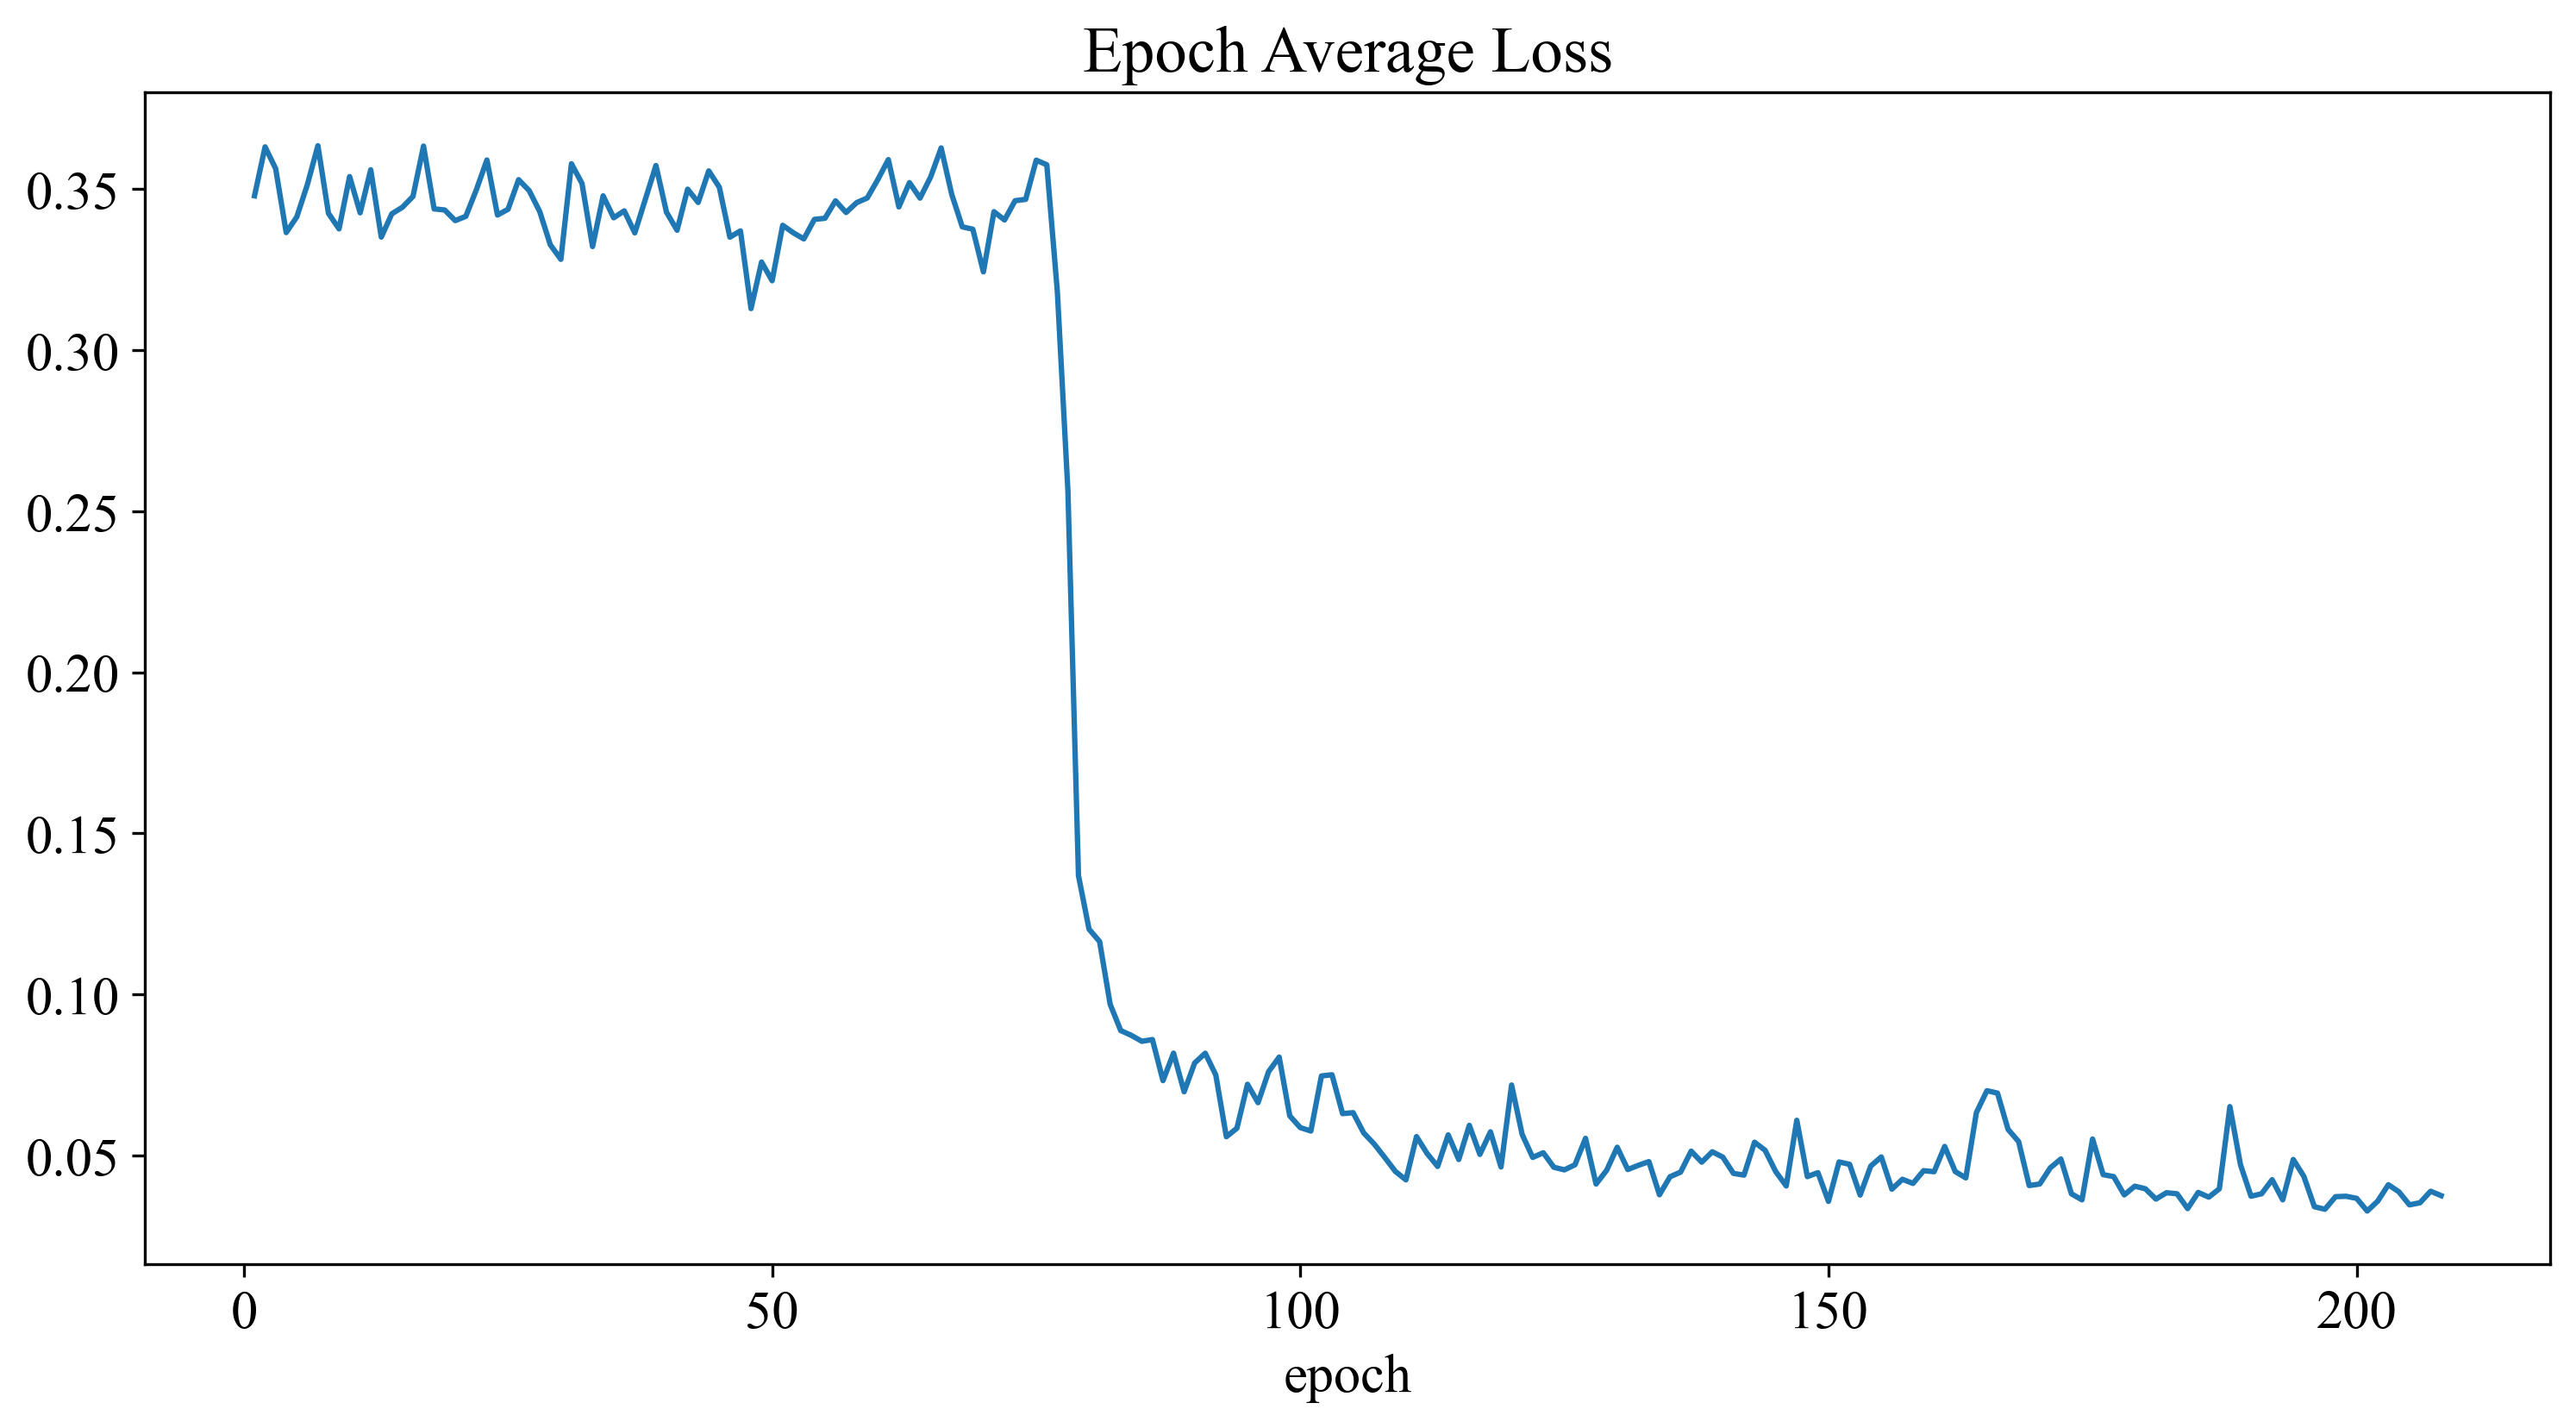

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 1, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
# plt.subplot(1, 2, 2)
# plt.title("Val Mean Dice")
# x = [val_interval * (i + 1) for i in range(len(metric_values))]
# y = metric_values
# plt.xlabel("epoch")
# plt.plot(x, y)
plt.savefig(f'img/{mtype}_{sel_modal}_train_process.svg', bbox_inch='tight')
plt.show()

In [18]:
from monai.transforms import KeepLargestConnectedComponentd, RemoveSmallObjectsd
import SimpleITK as sitk
import numpy as np
from monai.config import KeysCollection
from monai.transforms import MapTransform


class RemoveSmallObjectsPerLabel(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False,
                 min_size=64, verbose: bool = False, force2: int = 0):
        MapTransform.__init__(self, keys, allow_missing_keys)
        self.min_size = min_size
        self.verbose = verbose
        self.force2 = force2

    def __call__(self, data):
        for k in self.keys:
            batch_data = []
            for idx in range(data[k].shape[0]):
                sel_data = np.array(data[k][idx]).astype(int)
                print(sel_data.shape)
                sel_data = sitk.GetImageFromArray(sel_data)
                sitk.WriteImage(sel_data, f"{idx}.nii.gz")
                cc_filter = sitk.ConnectedComponentImageFilter()
                cc_filter.SetFullyConnected(True)
                omask_array = sitk.GetArrayFromImage(cc_filter.Execute(sel_data))
                unique_labels = np.unique(omask_array)
                mask_label_voxels = {}
                for ul in unique_labels:
                    mask_label_voxels[ul] = np.sum(omask_array == ul)
                mask_label_voxels = sorted(mask_label_voxels.items(), key=lambda x: x[1], reverse=True)
                mask_postprocess = np.ones_like(omask_array)
                for idx, (ul, cnt) in enumerate(mask_label_voxels):
                    if cnt < self.min_size:
                        mask_postprocess[omask_array == ul] = self.force2
                if self.verbose:
                    print(unique_labels, mask_label_voxels)
                batch_data.append(mask_postprocess * data[k])
            data[k] = np.array(batch_data)
        return data

val_t = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(1, 1, 1), mode=("bilinear")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=150,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image"]),
    ]
)

# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image"], allow_missing_keys=True),
#         EnsureChannelFirstd(keys=["image",], allow_missing_keys=True),
# #         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image",], pixdim=(0.5, 0.5, 3), mode=("bilinear"), allow_missing_keys=True),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=0, a_max=2500,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image",], source_key="image", allow_missing_keys=True),
#         EnsureTyped(keys=["image",], allow_missing_keys=True),
#     ]
# )
post_ori_t = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_t,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True),
        KeepLargestConnectedComponentd(keys='pred', num_components=1)
#         RemoveSmallObjectsPerLabel(keys='pred', min_size=5000, verbose=True)
    ]
)


### 预测

In [19]:
import glob
import os
from onekey_algo import OnekeyDS
from onekey_algo.segmentation3D.modelzoo.eval_3dsegmentation import init as init3d
from onekey_algo.segmentation3D.modelzoo.eval_3dsegmentation import inference as inference3d

root_dir = r'D:\20240420-LiXiaoFeng\images_re'
save_dir= os.path.join(root_dir, f'../{mtype}_infer')
model_root = r'D:\20240420-LiXiaoFeng\models'
sel_modal = 'CLS2'

mtype = 'vnet'
model_path = os.path.join(model_root, f'{mtype}_{sel_modal}.pth')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# for i in prefetch:
#     mask_img = i.replace('.nii.gz', '.mask.nii.gz')
#     if not os.path.exists(mask_img):
#         data.append(i)
num_classes = 2
roi_size = [64,64,64]
m, t, d = init3d('VNet', model_path=model_path, num_classes=num_classes, roi_size=roi_size)
d = 'cuda:0'
m = m.to(d)
data = glob.glob(os.path.join(root_dir, '*.nii.gz'))
# data = [i['image'] for i in val_files]
inference3d(data, model, (val_t, post_ori_t), d, roi_size=roi_size, save_dir=save_dir)

# for data_ in data:
#     inference3d([data_], m, (val_t, post_ori_t), d, 
#                 roi_size=roi_size, save_dir=os.path.dirname(data_), save_name=data_.replace('.nii.gz', '.infer.nii.gz'))

[2024-04-22 09:53:49 - eval_3dsegmentation.py:  91]	INFO	使用VNet模型，成功加载D:\20240420-LiXiaoFeng\models\vnet_CLS2.pth参数
[2024-04-22 09:53:49 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\AN ZAI YIN_P00149502.nii.gz'}
[2024-04-22 09:53:59 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\Bai-Qihai-P00262743.nii.gz'}
[2024-04-22 09:54:23 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\CAI_CHENG_DONG_P00173278.nii.gz'}
[2024-04-22 09:54:33 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\CAI_CONG_ZHI_P00581652.nii.gz'}
[2024-04-22 09:54:50 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\CAI_KE_RONG_P00217765.nii.gz'}
[2024-04-22 09:55:12 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\CAI_QING_YAN_P00304771.nii.gz'}
[2024-04-22 09:55:23 - eval_3dsegmentation.py:  

[2024-04-22 10:06:41 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\HE FENG YING,P00347123.nii.gz'}
[2024-04-22 10:06:49 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\He-Qingmo-P00326419.nii.gz'}
[2024-04-22 10:07:02 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\Hong-Yongzhi-P00176040.nii.gz'}
[2024-04-22 10:07:13 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\HU CUI PING,P00368120.nii.gz'}
[2024-04-22 10:07:26 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\HUANG MIN_P00070925.nii.gz'}
[2024-04-22 10:07:34 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\HUANG ZHI LIANG,P00347688.nii.gz'}
[2024-04-22 10:07:48 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\Huang-Jincai-P00181947.nii.gz'}
[2024-04-22 10:07:57 - e

[2024-04-22 10:19:19 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LIU_XIU_YUN_P00194230.nii.gz'}
[2024-04-22 10:19:26 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LI_AI_ZHI_P00293038.nii.gz'}
[2024-04-22 10:19:38 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LI_JIA_KUI_P00171075.nii.gz'}
[2024-04-22 10:19:50 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LI_LING_P00191054.nii.gz'}
[2024-04-22 10:20:00 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LI_WEN_CAI_P00203404.nii.gz'}
[2024-04-22 10:20:08 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LI_ZHI_MIN_P00301766.nii.gz'}
[2024-04-22 10:20:23 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LOU_SHU_GANG_P00314140.nii.gz'}
[2024-04-22 10:20:36 - eval_3dsegme

[2024-04-22 10:31:08 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\wang cui lan.nii.gz'}
[2024-04-22 10:31:21 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\WANG JIA YUN_P00137934.nii.gz'}
[2024-04-22 10:31:34 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\WANG KAI HE_P00153971.nii.gz'}
[2024-04-22 10:31:45 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\WANG LAN XIA_P00052496.nii.gz'}
[2024-04-22 10:31:56 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\WANG MEI CHUN,P00359851.nii.gz'}
[2024-04-22 10:32:09 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\WANG MING HUA_P00141062.nii.gz'}
[2024-04-22 10:32:29 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\wang qing zhong.nii.gz'}
[2024-04-22 10:32:39 - eval_3dsegmen

[2024-04-22 10:43:34 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\Zang_Fengyun_P00410951.nii.gz'}
[2024-04-22 10:43:45 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\ZHANG BU LIAN_P00351202.nii.gz'}
[2024-04-22 10:43:58 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\zhang de ju.nii.gz'}
[2024-04-22 10:44:10 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\ZHANG MEI YUN,P00338976.nii.gz'}
[2024-04-22 10:44:21 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\ZHANG QIU YAN_P00086252.nii.gz'}
[2024-04-22 10:44:44 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\ZHANG RUI LIAN_P00078605.nii.gz'}
[2024-04-22 10:44:52 - eval_3dsegmentation.py:  63]	INFO	正在预测{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\ZHANG XUE MEI_P00155613.nii.gz'}
[2024-04-22 10:45:05 - ev

In [5]:
import numpy as np
from monai.metrics import compute_average_surface_distance, compute_hausdorff_distance

def calc_dice(p_cls, l_cls):
    # cal the inter & conv
    s = p_cls + l_cls
    inter = len(np.where(s >= 2)[0])
    conv = len(np.where(s >= 1)[0]) + inter
    try:
        dice = 2.0 * inter / conv
    except:
        print("conv is zeros when dice = 2.0 * inter / conv")
        dice = None
    return dice

def calc_iou(p_cls, l_cls):
    # cal the inter & conv
    s = p_cls + l_cls
    inter = len(np.where(s >= 2)[0])
    conv = len(np.where(s >= 1)[0])
    try:
        iou = inter / conv
    except:
        print("conv is zeros when dice = 2.0 * inter / conv")
        iou = None
    return iou
    
def calc_sa(p_cls, l_cls):
    # cal the inter & conv
    error = np.bitwise_xor(p_cls, l_cls) & l_cls
    try:
        sa = 1 - np.sum(error) / np.sum(l_cls)
    except:
        print("SA segmentation is error!")
        sa = None
    return sa

def calc_os(p_cls, l_cls):
    # cal the inter & conv
    error = np.bitwise_xor(p_cls, l_cls) & p_cls
    try:
        over_s = np.sum(error) / (np.sum(l_cls) + np.sum(p_cls))
    except:
        print("Over segmentation is error!")
        over_s = None
    return over_s

def calc_us(p_cls, l_cls):
    # cal the inter & conv
    error = np.bitwise_xor(p_cls & l_cls, l_cls)
    try:
        us = np.sum(error) / (np.sum(l_cls) + np.sum(np.bitwise_xor(p_cls, l_cls) & p_cls))
    except:
        print("Under segmentation is error!")
        us = None
    return us

def calc_asd(p_cls, l_cls):
    asd = compute_average_surface_distance(p_cls[np.newaxis, np.newaxis, :], l_cls[np.newaxis, np.newaxis, :])
    return float(asd)

def calc_hausdorff_distance(p_cls, l_cls): 
    hd = compute_hausdorff_distance(p_cls[np.newaxis, np.newaxis, :], l_cls[np.newaxis, np.newaxis, :])
    return float(hd)

def seg_eval(pred, label, clss=[0, 1]):
    """
    calculate the dice between prediction and ground truth
    input:
        pred: predicted mask
        label: groud truth
        clss: eg. [0, 1] for binary class
    """
    Ncls = len(clss)
    eval_matric = [None] * Ncls
    [depth, height, width] = pred.shape
    for idx, cls in enumerate(clss):
        # binary map
        pred_cls = np.zeros([depth, height, width], dtype=np.uint8)
        pred_cls[np.where(pred == cls)] = 1
        label_cls = np.zeros([depth, height, width], dtype=np.uint8)
        label_cls[np.where(label == cls)] = 1

        metric = [calc_dice(pred_cls, label_cls), calc_iou(pred_cls, label_cls), 
                  calc_sa(pred_cls, label_cls), calc_os(pred_cls, label_cls), calc_us(pred_cls, label_cls), 
#                   calc_asd(pred_cls, label_cls), calc_hausdorff_distance(pred_cls, label_cls)
                 ]
        eval_matric[idx] = metric

    return eval_matric

### 后处理

In [8]:
from glob import glob
import SimpleITK as sitk
import os
import numpy as np
import pandas as pd

root = rf'D:\20240420-LiXiaoFeng\vnet_infer'
metric_names = ['Dice', 'mIOU', 'SA', 'OS', 'US']

cohort_metric = []

for fs in [train_files, val_files]:
    all_metrics = []
    for gt in fs:
        gt_mask = gt['label']
        pred_mask = os.path.join(root, os.path.basename(gt_mask))
        all_metrics.append(seg_eval(sitk.GetArrayFromImage(sitk.ReadImage(pred_mask)),
                                    sitk.GetArrayFromImage(sitk.ReadImage(gt_mask))))
    metric = pd.DataFrame(np.mean(np.array(all_metrics), axis=1), columns=metric_names)
    cohort_metric.append(pd.DataFrame(metric.mean(axis=0)).T)

In [11]:
val_files

[{'image': 'D:\\20240420-LiXiaoFeng\\images_re\\FENG_JUN_PING_P00301751.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\FENG_JUN_PING_P00301751.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\DONG_YU_MEI_P00175700.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\DONG_YU_MEI_P00175700.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\CHEN AI QIU_P00162124.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\CHEN AI QIU_P00162124.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LIU_XIU_YUN_P00194230.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\LIU_XIU_YUN_P00194230.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\ZHU_SHI_HUAN_P00291363.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\ZHU_SHI_HUAN_P00291363.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\LIU SHIP00368368.nii.gz',
  'label': 'D:\\20240420-LiXiaoFeng\\masks_re\\LIU SHIP00368368.nii.gz'},
 {'image': 'D:\\20240420-LiXiaoFeng\\images_re\\XU_QIANG

In [20]:
a = pd.DataFrame(pd.DataFrame(np.mean(np.array(all_metrics)[:,1:,], axis=1), columns=metric_names))
a['fname'] = [os.path.basename(v['image']) for v in val_files]
a

,Dice,mIOU,SA,OS,US,fname
0,0.249,0.142,0.142,0.002,0.855,FENG_JUN_PING_P00301751.nii.gz
1,0.764,0.618,0.823,0.155,0.133,DONG_YU_MEI_P00175700.nii.gz
2,0.000,0.000,0.000,0.652,0.348,CHEN AI QIU_P00162124.nii.gz
3,0.781,0.641,0.653,0.011,0.341,LIU_XIU_YUN_P00194230.nii.gz
4,0.806,0.674,0.752,0.062,0.222,ZHU_SHI_HUAN_P00291363.nii.gz
5,0.848,0.736,0.857,0.081,0.123,LIU SHIP00368368.nii.gz
6,0.006,0.003,0.003,0.000,0.997,XU_QIANG_P00191915.nii.gz
7,0.909,0.833,0.872,0.024,0.123,Yang_Qijin_P00509273.nii.gz
8,0.247,0.141,0.144,0.021,0.836,ZHOU YU PING_P00170755.nii.gz
9,0.880,0.785,0.805,0.014,0.190,YAN_SHI_YONG_P00013001.nii.gz


In [9]:
m = pd.concat(cohort_metric, axis=0)
m['cohort'] = ['Train', 'Val']
m

,Dice,mIOU,SA,OS,US,cohort
0,0.818,0.759,0.779,0.030,0.201,Train
0,0.817,0.761,0.780,0.029,0.201,Val


In [ ]:
import SimpleITK as sitk
import os
import numpy as np
import pandas as pd

# mtype='unetr'
metric_names = ['Dice', 'mIOU', 'SA', 'OS', 'US', 'ASD', 'HD']
data = [vf['image'] for vf in val_files] + [vf['image'] for vf in train_files]
all_metrics = []
for mtype in ['Unet_']:
    metrics = []
    for data_ in data:
        mask_path = data_.replace('.nii.gz', '.infer.nii.gz')
        gt_mask = sitk.GetArrayFromImage(sitk.ReadImage(data_.replace('.nii.gz', '.mask.nii.gz')))
        itk_mask = sitk.ReadImage(mask_path)
        cc_filter = sitk.ConnectedComponentImageFilter()
        cc_filter.SetFullyConnected(True)
        omask_arry = sitk.GetArrayFromImage(cc_filter.Execute(itk_mask))
        unique_labels = np.unique(omask_arry)
        mask_label_voxels = {}
        for ul in unique_labels:
            mask_label_voxels[ul] = np.sum(omask_arry == ul)
        mask_label_voxels = sorted(mask_label_voxels.items(), key=lambda x: x[1], reverse=True)
        mask_postprocess = np.zeros_like(omask_arry)
        for idx, (ul, cnt) in enumerate(mask_label_voxels):
            if 0 < idx < 3:
                mask_postprocess[omask_arry == ul] = 1
        print(mask_path, mask_label_voxels[:4])
        itk_mask = sitk.GetImageFromArray(mask_postprocess)
        sitk.WriteImage(itk_mask, data_.replace('.nii.gz', '.post.nii.gz'))
        metrics.append([seg_eval(sitk.GetArrayFromImage(sitk.ReadImage(mask_path)), gt_mask), seg_eval(mask_postprocess, gt_mask)])
#     print(metrics[-1])
    mm = pd.DataFrame(np.mean(np.array(metrics)[:, :, 1, ...], axis=0), columns= metric_names, index=['Origin', 'PostProcess'])
    mm['ModelName'] = mtype[:-1]
    all_metrics.append(mm)
    
pd.concat(all_metrics, axis=0)

In [ ]:
pd.DataFrame(np.mean(np.array(metrics)[:, :, 1, ...], axis=0), columns= metric_names, index=['Origin', 'Post'])

In [ ]:
import SimpleITK as sitk
import os
import numpy as np
import pandas as pd
import glob

# mtype='unetr'
# root = r'D:/20230327-ZhangKe/data/'
# data = glob.glob(os.path.join(root, '*', '*infer.nii.gz'))
data_ = r'H:/20230321-SongXueFei/data/501-600/574/574_2019-01-28/02_T1W_TSE .infer.nii.gz'
for data_ in [data_]:
    mask_path = data_
    itk_mask = sitk.ReadImage(mask_path, sitk.sitkUInt8)
    cc_filter = sitk.ConnectedComponentImageFilter()
    cc_filter.SetFullyConnected(True)
    omask_arry = sitk.GetArrayFromImage(cc_filter.Execute(itk_mask))
    unique_labels = np.unique(omask_arry)
    mask_label_voxels = {}
    for ul in unique_labels:
        mask_label_voxels[ul] = np.sum(omask_arry == ul)
    mask_label_voxels = sorted(mask_label_voxels.items(), key=lambda x: x[1], reverse=True)
    mask_postprocess = np.zeros_like(omask_arry)
    for idx, (ul, cnt) in enumerate(mask_label_voxels):
        if 0 < idx < 3:
            mask_postprocess[omask_arry == ul] = 1
    print(mask_path, mask_label_voxels[:4])
    itk_mask = sitk.GetImageFromArray(mask_postprocess)
    sitk.WriteImage(itk_mask, data_.replace('.nii.gz', '.post.nii.gz'))

In [ ]:
import shutil
root = r'D:/20230327-ZhangKe/data/'
data = glob.glob(os.path.join(root, '*', '*infer.post.nii.gz'))
for d in data:
    shutil.move(d, d.replace('infer.post.nii.gz', 'post.nii.gz'))